In [1]:
import numpy as np
import torch
from torch import nn, optim
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42


Bad key "text.kerning_factor" on line 4 in
/groups/spruston/home/sunw2/anaconda3/envs/vr2pai/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
def Teacher_Student_Correlated(N,P,P_test,SNR,nepoch,repeat,corr):
    
    Et = np.zeros((nepoch,repeat))
    Eg = np.zeros((nepoch,repeat))

    for r in range(repeat):
        #print(r)
        
        torch.manual_seed(r)


        if SNR == np.inf:
            variance_w = 1;
            variance_e = 0;
        else:
            variance_w = SNR/(SNR + 1);
            variance_e = 1/(SNR + 1);
            

        noise_train = torch.normal(0, variance_e**0.5, size = [P,1])
        noise_test = torch.normal(0, variance_e**0.5, size = [P_test,1])


        W_t = torch.normal(0, variance_w**0.5, size=(N, 1))
        
        # generate a pool of examples
        mean = np.zeros(P)
        cov = np.eye(P)
        cov[~np.eye(P,dtype = bool)]= corr
        
        train_x = np.random.multivariate_normal(mean, cov, N)
        train_x = train_x*(1/N)**0.5
        train_x = torch.from_numpy(train_x).float().T

        #train_x = torch.normal(0, (1/N)**0.5, size=(P, N))
        train_y = torch.matmul(train_x, W_t) + noise_train
        
        # generate test set
        test_x = torch.normal(0, (1/N)**0.5, size=(P_test, N))
        test_y = torch.matmul(test_x, W_t) + noise_test
        

        model = nn.Sequential(nn.Linear(N,1,bias=False))
        optimizer = optim.SGD(model.parameters(), lr=0.01*(N/2)) # to match the learnrate in the matlab implementation.
        
        # set student's weights to 0
        with torch.no_grad():
            list(model.parameters())[0].zero_()

        for i in range(nepoch):
            optimizer.zero_grad()
            train_error = criterion(train_y, model(train_x))
            train_error.backward()
            optimizer.step()
            Et[i,r] = train_error.detach().numpy()
            with torch.no_grad():
                test_error = criterion(test_y, model(test_x))
                Eg[i,r] = test_error.numpy()
    return Et,Eg
 
  
    
def criterion(y, y_hat):
    return (y - y_hat).pow(2).mean()


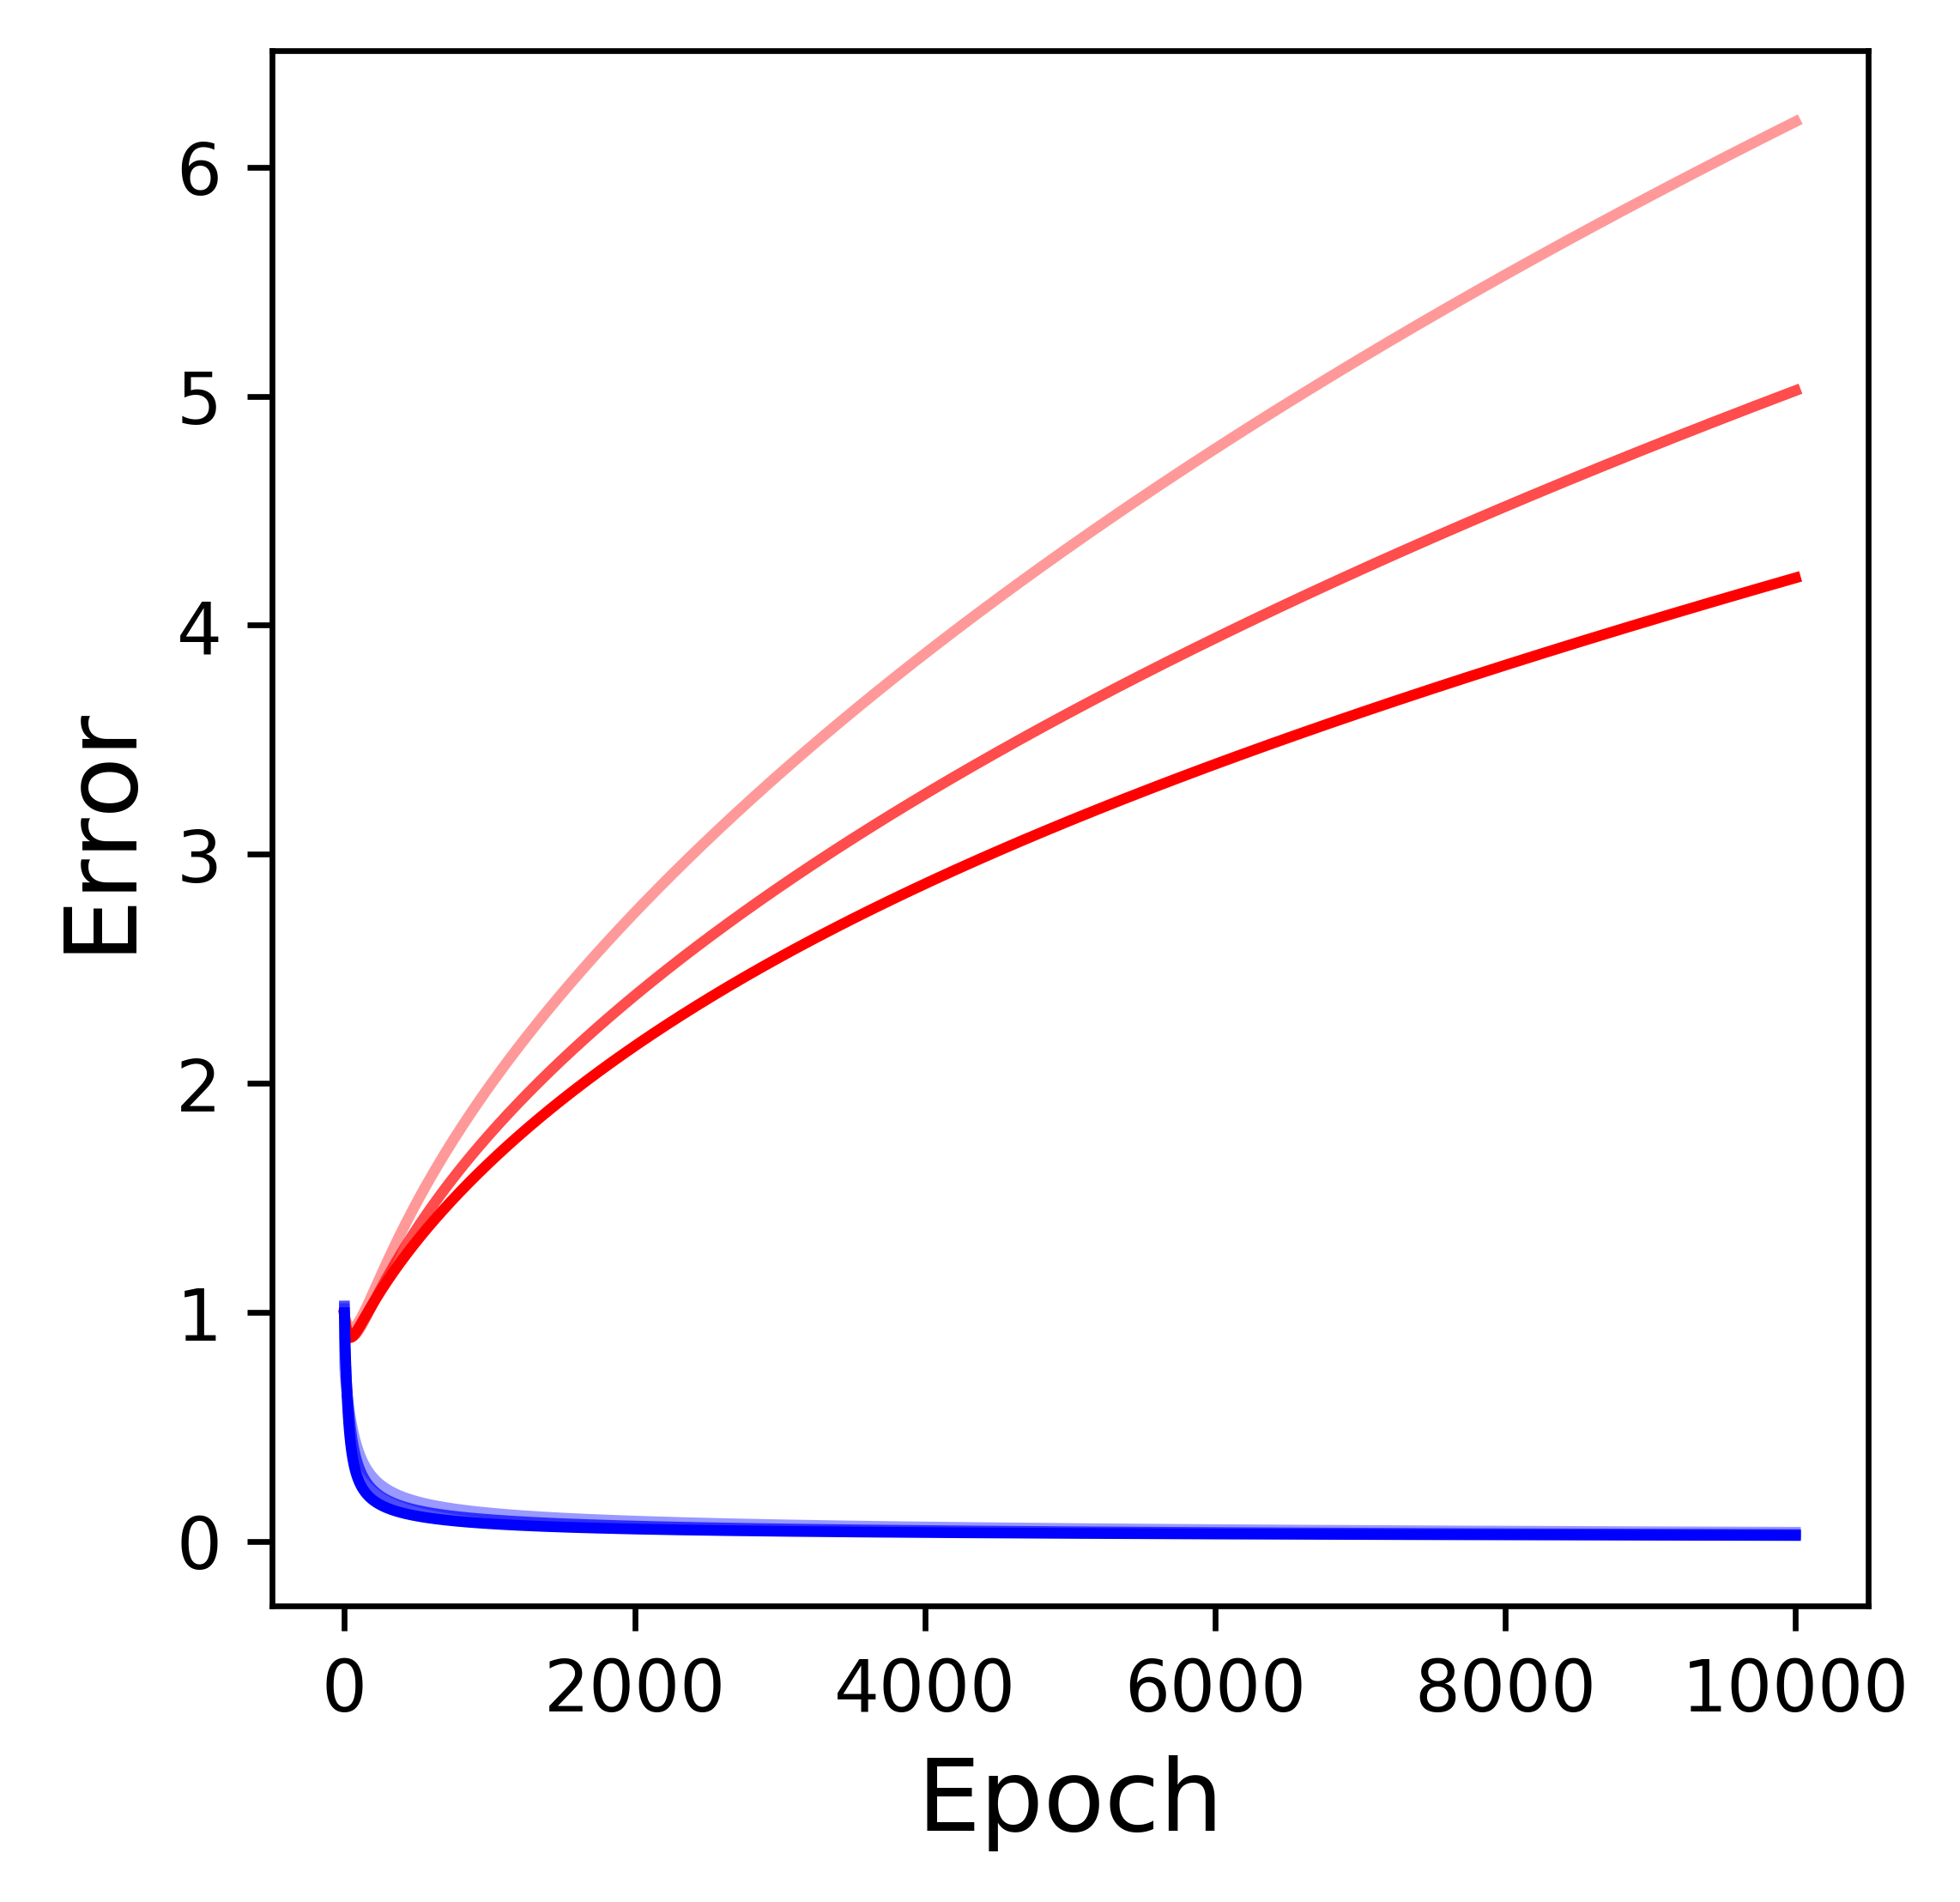

In [3]:
#SNR = np.inf
SNR = 0.6
nepoch = 10000
repeat = 50
N = 100
P = 100
P_test = 1000

Et_big = np.zeros((nepoch,repeat))
Eg_big = np.zeros((nepoch,repeat))

plt.figure(figsize = (4,4),dpi =600)

for corr in [0,0.3,0.6]:
    Et_big, Eg_big= Teacher_Student_Correlated(N,P,P_test,SNR,nepoch,repeat,corr)

    plt.plot(Eg_big.mean(1),'r', alpha = 1-corr, label = 'Generalization',rasterized=False,zorder=1)
    plt.plot(Et_big.mean(1),'b',alpha = 1-corr, label = 'Memory',rasterized=False)
    plt.xlabel('Epoch',fontsize = '14')
    plt.ylabel('Error',fontsize = '14')
#plt.legend()

#plt.savefig(f'fig_SNR={SNR}.pdf')

In [4]:
#SNR = np.inf
SNR = 0.6
corr = 0.8
nepoch = 2000
repeat = 50
N = 100

P_test = 1000

Et_big_decorr = np.zeros((nepoch,repeat))
Eg_big_decorr = np.zeros((nepoch,repeat))

Et_big_corr = np.zeros((nepoch,repeat))
Eg_big_corr = np.zeros((nepoch,repeat))


Eg_end_decorr = []
Eg_end_corr = []


for i,alpha in enumerate(np.arange(0.1,5.1,0.1)):
    
    P = int(np.floor(N*alpha))
    print(P)
    
    Et_big_decorr, Eg_big_decorr = Teacher_Student_Correlated(N,P,P_test,SNR,nepoch,repeat,corr = 0)
    Et_big_corr, Eg_big_corr = Teacher_Student_Correlated(N,P,P_test,SNR,nepoch,repeat,corr = 0.6)

    Eg_end_decorr.append(Eg_big_decorr[-1,:].mean())
    Eg_end_corr.append(Eg_big_corr[-1,:].mean())

#     plt.plot(Eg_big.mean(1),'r', alpha = 1-corr, label = 'Generalization',rasterized=False,zorder=1)
#     plt.plot(Et_big.mean(1),'b',alpha = 1-corr, label = 'Memory',rasterized=False)
#     plt.xlabel('Epoch',fontsize = '14')
#     plt.ylabel('Error',fontsize = '14')
#plt.legend()

#plt.savefig(f'fig_SNR={SNR}.pdf')

10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
409
420
430
439
450
459
470
480
490
500


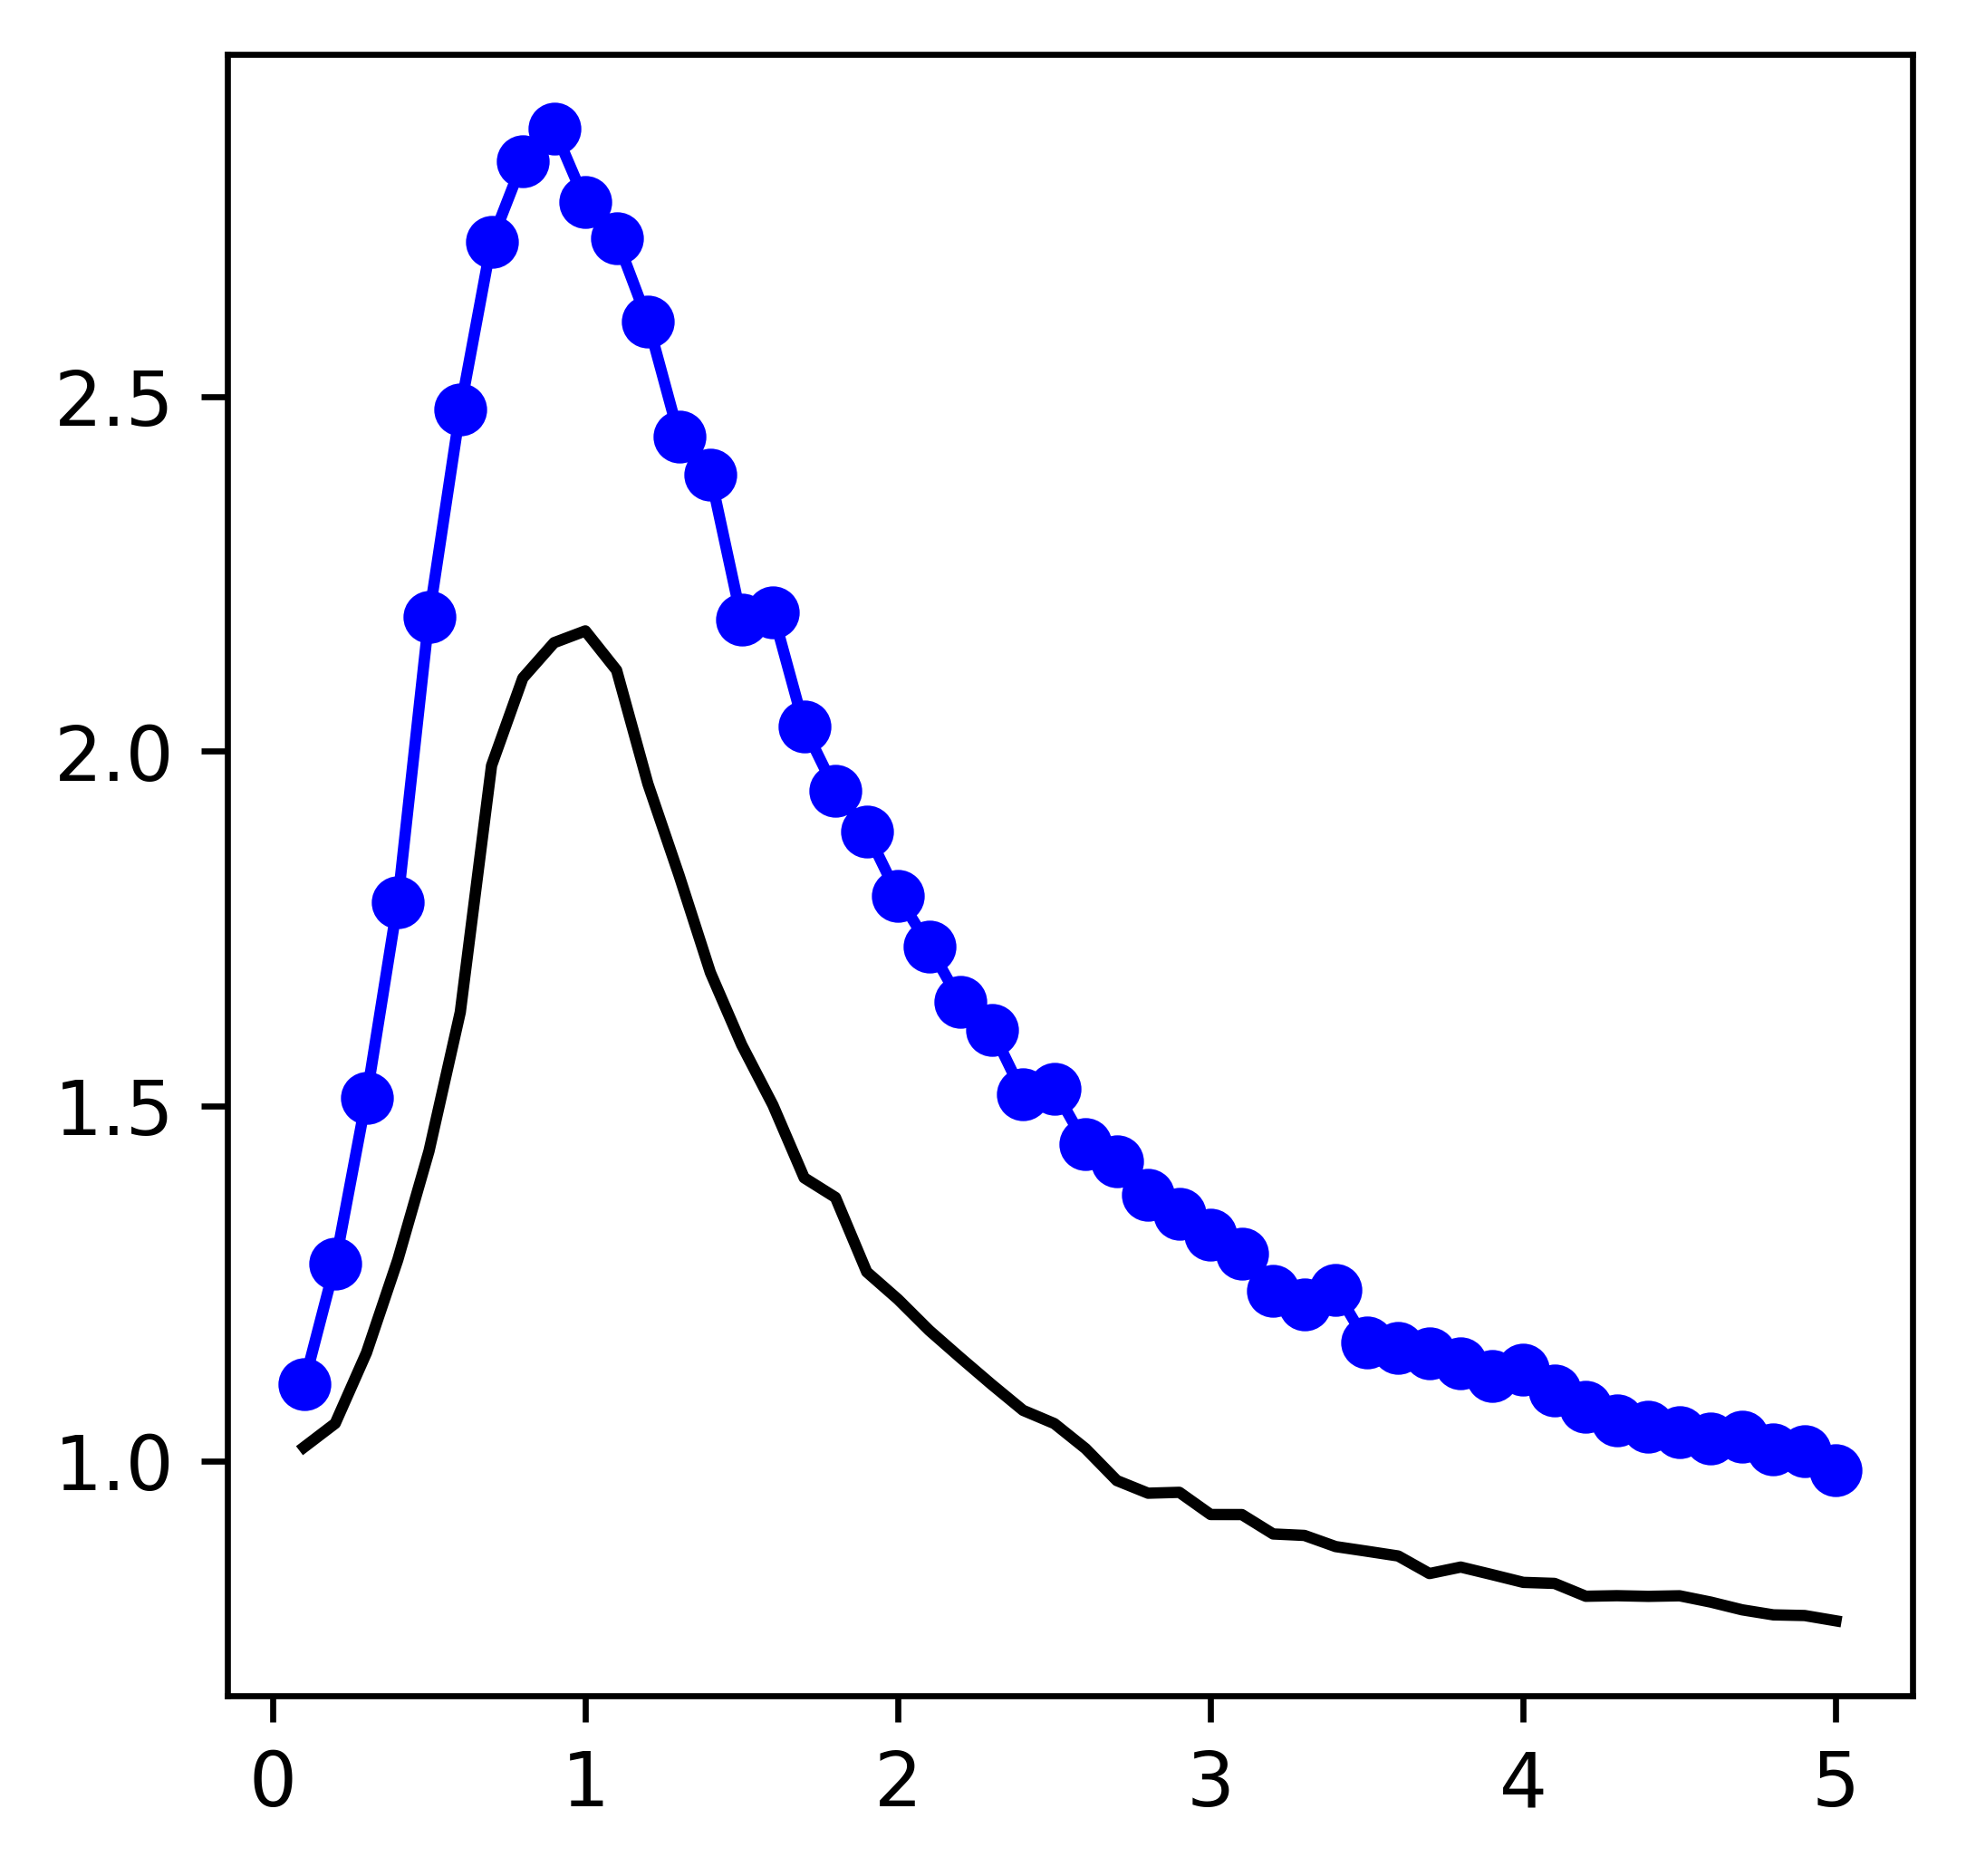

In [19]:
plt.figure(figsize = (4,4),dpi =600)

plt.plot(np.arange(0.1,5.1,0.1),Eg_end_decorr,'k-')
plt.plot(np.arange(0.1,5.1,0.1),Eg_end_corr,'bo-')
#plt.savefig('corr_decorr_double_descent.pdf')

In [6]:
def Teacher_Student_Biased(N,P,P_test,SNR,nepoch,repeat,corr,sample_method):
    
    Et = np.zeros((nepoch,repeat))
    Eg = np.zeros((nepoch,repeat))

    for r in range(repeat):
        #print(r)
        
        torch.manual_seed(r)


        if SNR == np.inf:
            variance_w = 1;
            variance_e = 0;
        else:
            variance_w = SNR/(SNR + 1);
            variance_e = 1/(SNR + 1);
            

        noise_train = torch.normal(0, variance_e**0.5, size = [P,1])
        noise_test = torch.normal(0, variance_e**0.5, size = [P_test,1])


        W_t = torch.normal(0, variance_w**0.5, size=(N, 1))
        
        # generate a pool of examples
        mean = np.zeros(P)
        cov = np.eye(P)
        cov[~np.eye(P,dtype = bool)]= corr
        
        train_x = np.random.multivariate_normal(mean, cov, N)
        train_x = train_x*(1/N)**0.5
        train_x = torch.from_numpy(train_x).float().T

        #train_x = torch.normal(0, (1/N)**0.5, size=(P, N))
        train_y = torch.matmul(train_x, W_t) + noise_train
        
        # generate test set
        test_x = torch.normal(0, (1/N)**0.5, size=(P_test, N))
        test_y = torch.matmul(test_x, W_t) + noise_test
        

        model = nn.Sequential(nn.Linear(N,1,bias=False))
        optimizer = optim.SGD(model.parameters(), lr=0.01*(N/2)) # to match the learnrate in the matlab implementation.
        
        # set student's weights to 0
        with torch.no_grad():
            list(model.parameters())[0].zero_()

        for i in range(nepoch):
            optimizer.zero_grad()
            if sample_method == 'biased':
            #biased sampling per epoch
                probs = np.exp(-np.arange(0,2,2/P))/np.exp(-np.arange(0,2,2/P)).sum()
                biased_sample_ind = np.random.choice(np.arange(0, P),P,p = probs)
                train_x_sample = train_x[biased_sample_ind]
                train_error = criterion(train_y[biased_sample_ind], model(train_x_sample))
            if sample_method == 'uniform':
                train_error = criterion(train_y, model(train_x))
            train_error.backward()
            optimizer.step()
            Et[i,r] = train_error.detach().numpy()
            with torch.no_grad():
                test_error = criterion(test_y, model(test_x))
                Eg[i,r] = test_error.numpy()
    return Et,Eg

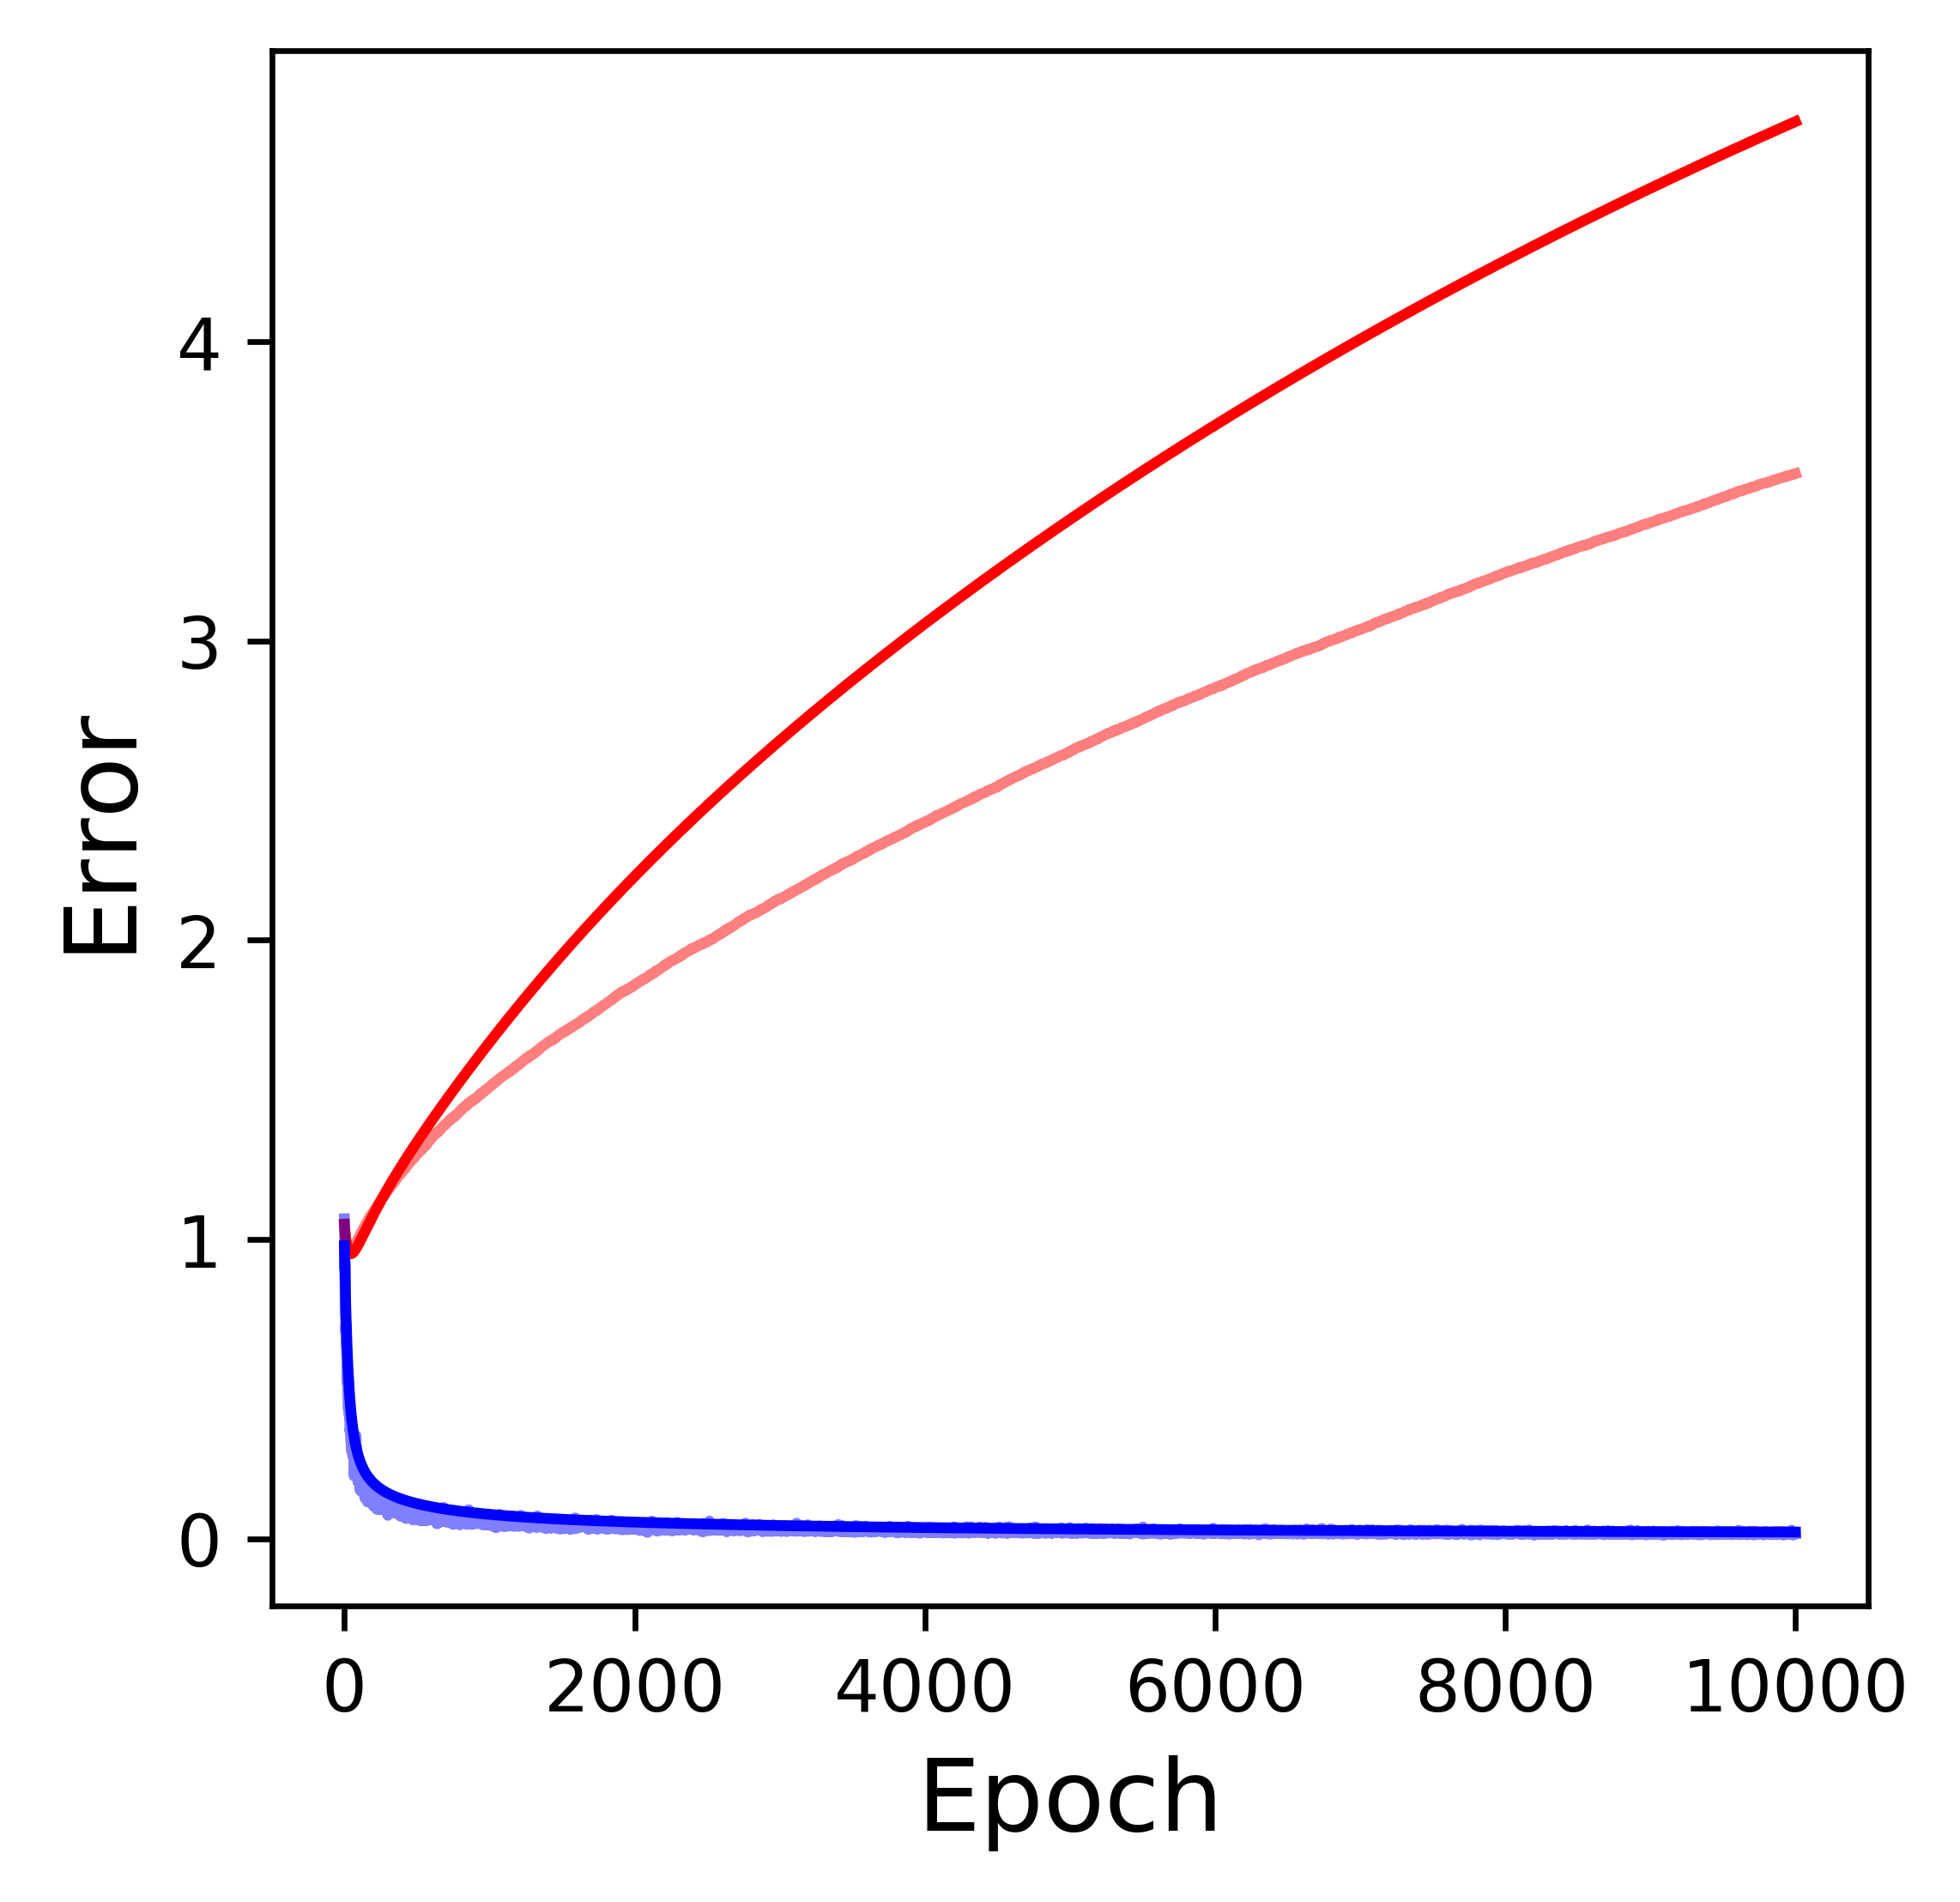

In [7]:
#SNR = np.inf
SNR = 0.6
nepoch = 10000
repeat = 3
N = 100
P = 100
P_test = 1000
corr = 0

Et_big = np.zeros((nepoch,repeat))
Eg_big = np.zeros((nepoch,repeat))

plt.figure(figsize = (4,4),dpi =600)


Et_biased, Eg_biased = Teacher_Student_Biased(N,P,P_test,SNR,nepoch,repeat,corr, 'biased')
Et_uni, Eg_uni = Teacher_Student_Biased(N,P,P_test,SNR,nepoch,repeat,corr, 'uniform')


plt.plot(Eg_biased.mean(1),'r', alpha = 0.5, label = 'Generalization',rasterized=False,zorder=1)
plt.plot(Et_biased.mean(1),'b',alpha = 0.5, label = 'Memory',rasterized=False)
plt.plot(Eg_uni.mean(1),'r', alpha = 1, label = 'Generalization',rasterized=False,zorder=1)
plt.plot(Et_uni.mean(1),'b',alpha = 1, label = 'Memory',rasterized=False)
plt.xlabel('Epoch',fontsize = '14')
plt.ylabel('Error',fontsize = '14')
#plt.legend()

plt.savefig(f'fig_SNR={SNR}_sampling.pdf')

10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
409
420
430
439
450
459
470
480
490
500


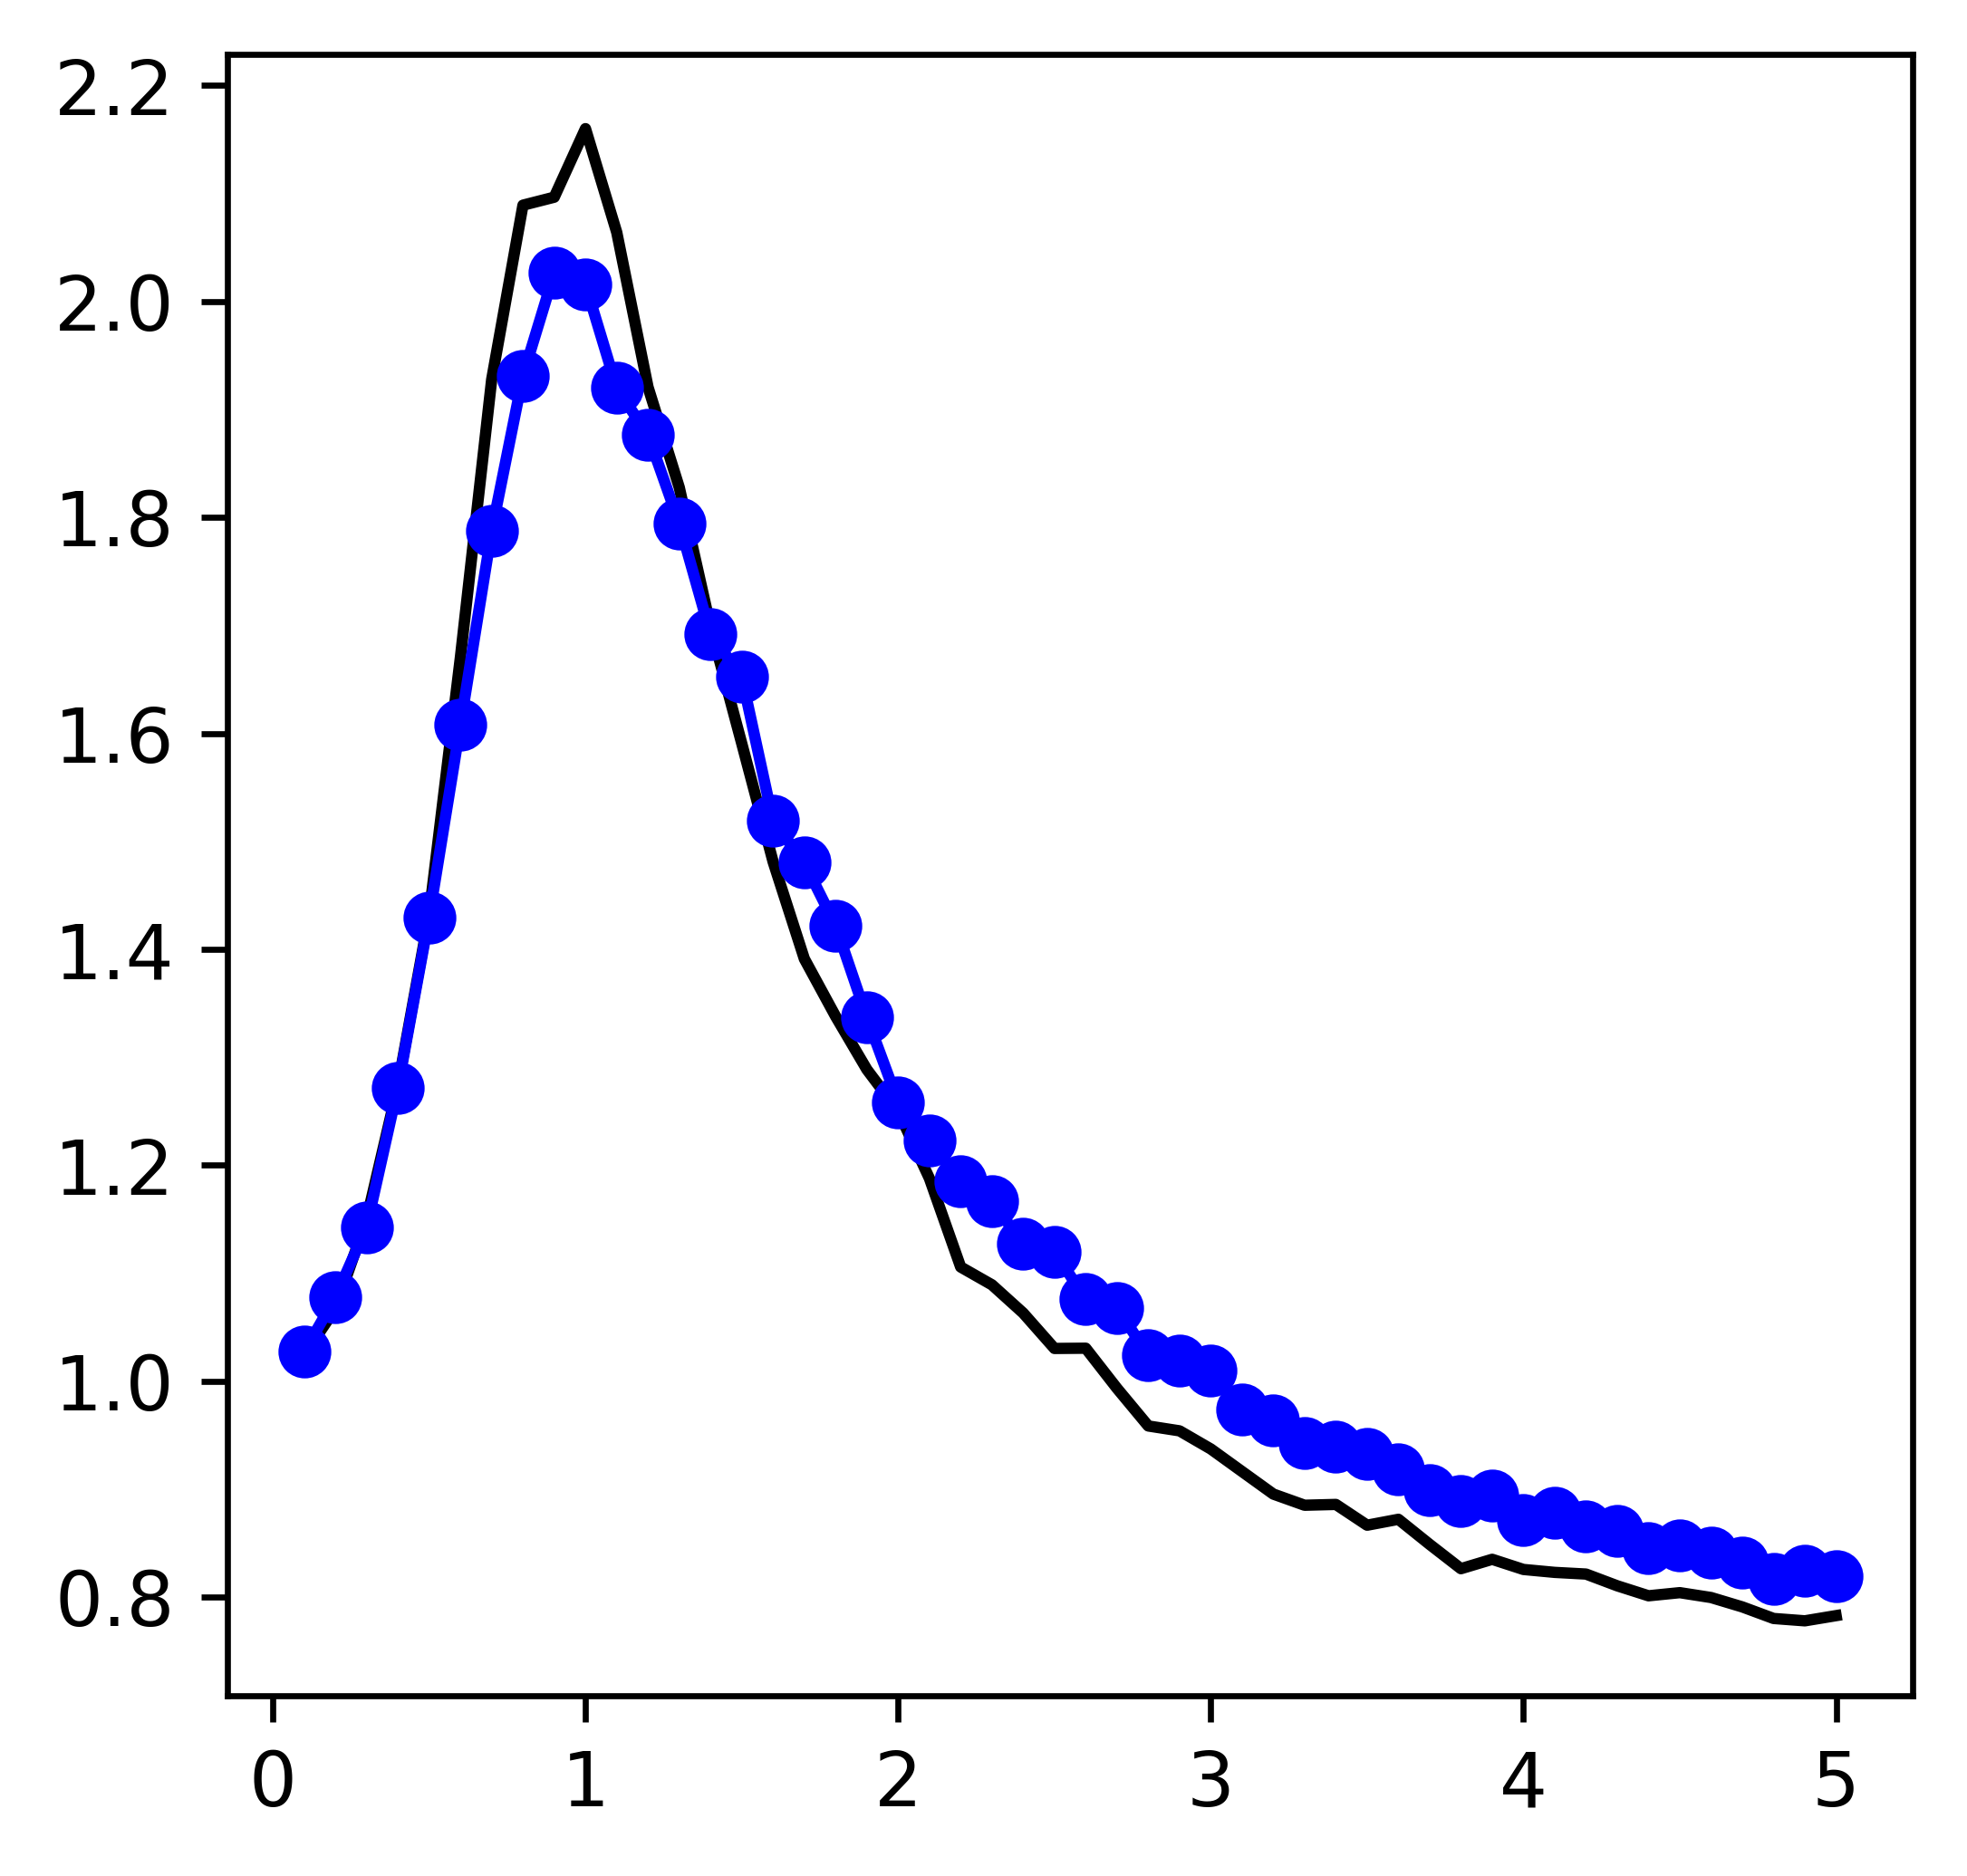

In [20]:
#SNR = np.inf
SNR = 0.6
corr = 0
nepoch = 2000
repeat = 50
N = 100

P_test = 1000

Et_big_uniform = np.zeros((nepoch,repeat))
Eg_big_uniform = np.zeros((nepoch,repeat))

Et_big_biased = np.zeros((nepoch,repeat))
Eg_big_biased = np.zeros((nepoch,repeat))


Eg_end_uniform = []
Eg_end_biased = []


for i,alpha in enumerate(np.arange(0.1,5.1,0.1)):
    
    P = int(np.floor(N*alpha))
    print(P)
    
    Et_big_uniform, Eg_big_uniform = Teacher_Student_Biased(N,P,P_test,SNR,nepoch,repeat,corr,'uniform')
    Et_big_biased, Eg_big_biased = Teacher_Student_Biased(N,P,P_test,SNR,nepoch,repeat,corr,'biased')

    Eg_end_uniform.append(Eg_big_uniform[-1,:].mean())
    Eg_end_biased.append(Eg_big_biased[-1,:].mean())
    
plt.figure(figsize = (4,4),dpi =600)

plt.plot(np.arange(0.1,5.1,0.1),Eg_end_uniform,'k-')
plt.plot(np.arange(0.1,5.1,0.1),Eg_end_biased,'bo-')
plt.savefig('uniform_biased_double_descent.pdf')



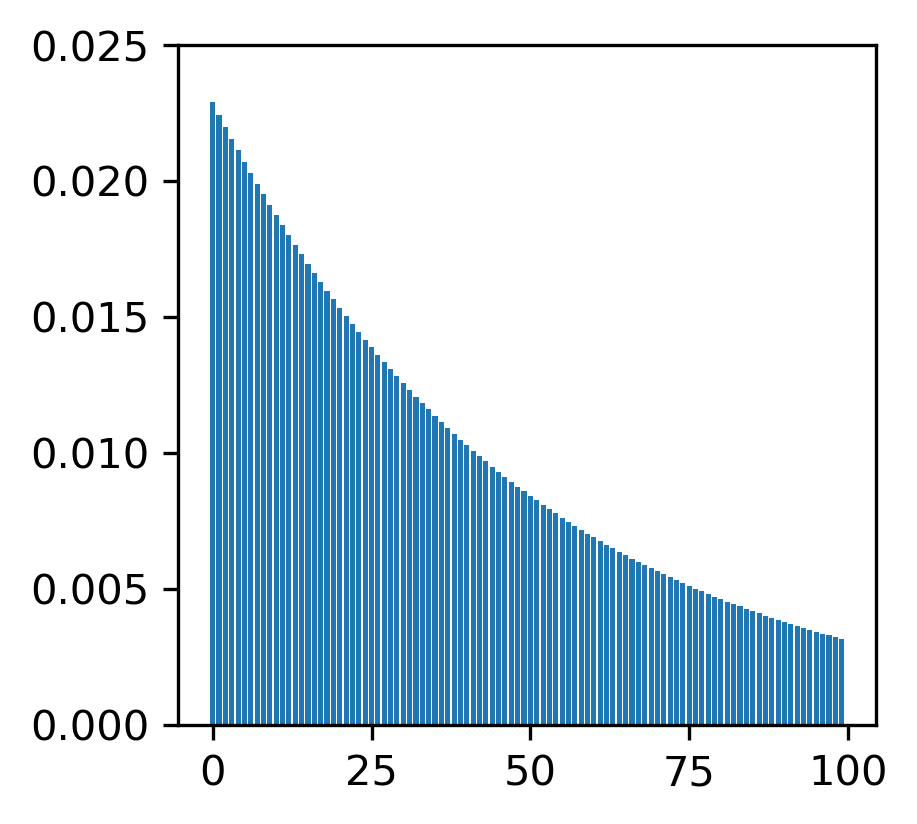

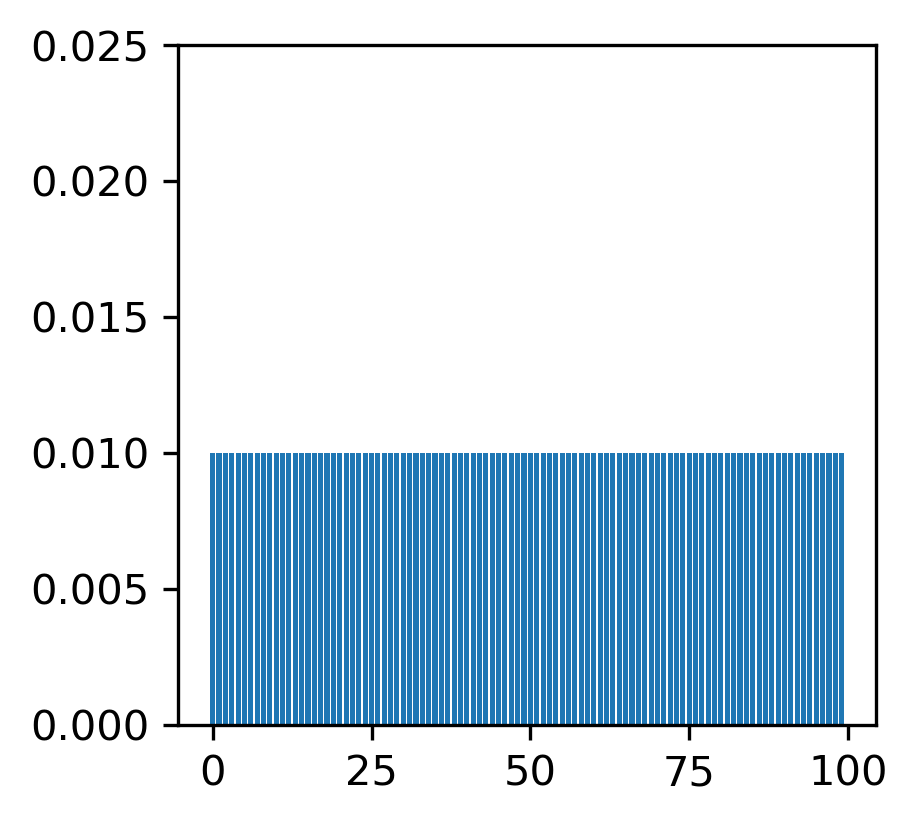

In [9]:
probs = np.exp(-np.arange(0,2,2/P))/np.exp(-np.arange(0,2,2/P)).sum()

plt.figure(figsize = (3,3),dpi = 300)
plt.bar(range(100),probs)
plt.ylim(0,0.025)
plt.savefig(f'fig_probs_biased.pdf')

plt.figure(figsize = (3,3),dpi = 300)
plt.bar(range(100),np.ones(P)*1/P)
plt.ylim(0,0.025)
plt.savefig(f'fig_probs_uniform.pdf')